# DFUC24 Baseline: DinoV2 training + validation for ulcer semantic segmentation on DFUC22 dataset

In this notebook, we will train classifiers on a frozen [DINOv2](https://huggingface.co./docs/transformers/main/model_doc/dinov2) backbone for semantic segmentation. 

The figure below illustrates the basic idea: we will train (none-) linear transformations on top of the frozen DINOv2 backbone. This transformation converts the features (patch embeddings) into a low-dimensional binary logits segmentation map, which is then upsampled. The final binary logits segmentation map will have a shape of (batch_size, 1, height, width), where each pixel is classified as either belonging to the ulcer (1) class or the background (0) class.

<img src="https://huggingface.co./datasets/nielsr/sample-images/resolve/main/dinov2_linear_classifier_bis.png"
alt="drawing" width="300"/>

The author of this notebook is Benjamin Bracke ([Github](https://github.com/B-Bracke)). Special thanks to Niels Rogge on [Github](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DINOv2/Train_a_linear_classifier_on_top_of_DINOv2_for_semantic_segmentation.ipynb), upon which this notebook is based.

## Imports

In [20]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler
from torch import autocast
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch.losses import DiceLoss

from torchmetrics import MetricCollection
from torchmetrics.aggregation import MeanMetric
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score, BinaryRecall, BinaryPrecision, BinaryConfusionMatrix

#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

## Defining important path variables

In [ ]:
ROOT_DIR = os.path.abspath(os.getcwd()) # current path of the notebook
MODEL_DIR = os.path.join(ROOT_DIR, "./models/dinov2_linear_probing") # path were the model checkpoints, logs, etc. will be saved
os.makedirs(MODEL_DIR, exist_ok=True) # create the directory if it does not exist

DATA_DIR = "./dfuc2022/sep/" # path to the dataset root directory
IMAGE_FILES = os.path.join(DATA_DIR, "images/") # path to the images
MASK_FILES = os.path.join(DATA_DIR, "labels/") # path to the ground truth masks

print("Directories:")
print("Root directory:", ROOT_DIR)
print("Model directory:", MODEL_DIR)
print("Image files in directory:", IMAGE_FILES)
print("Ground Truth Mask files in directory:", MASK_FILES)

## Data set

### Define the dataset class and pre-processing and augmentation pipelines

In [9]:
IMAGE_SIZE = 518 # image size for the model input (H and W)
NORM_MEAN = (0.485, 0.456, 0.406) # mean values for normalization
NORM_STD = (0.229, 0.224, 0.225) # standard deviation values for normalization

class DFUC2022_Dataset(Dataset):
    """
    Custom PyTorch Dataset class for the DFUC2022 dataset that loads the images and masks and applies the albumentation augmentation pipeline.
    image_files: list of image filenames
    mask_files: list of mask filenames
    transform: albumentation augmentation pipeline
    """
    def __init__(self, image_files:list, mask_files:list , transform=None):
        self.image_files = image_files # list of image filenames
        self.mask_files = mask_files # list of mask filenames
        self.transform = transform # albumentation augmentation pipeline

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_file = self.image_files[index]
        mask_file = self.mask_files[index]
        
        # load image and mask files as numpy array using opencv
        img = cv2.cvtColor(cv2.imread(img_file, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE) 

        # apply albumentation augmentation pipeline
        transformed = self.transform(image=img, mask=mask)
        img, mask = transformed['image'].float(), transformed['mask'].float()
        return (img, mask)

# albumentation pre-processing and augmentation pipeline for the training images
train_transform = A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE), # resize the image to the desired model input size
        A.Flip(p=0.5), # flip the image horizontally with a probability of 0.5
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5), # apply color jitter with a probability of 0.5
        A.Normalize(mean=NORM_MEAN, std=NORM_STD), # normalize the image
        ToTensorV2(), # convert the image to tensor
    ])

# albumentation pre-processing pipeline for the validation images
valid_transform = A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(mean=NORM_MEAN, std=NORM_STD),
        ToTensorV2(),
    ])

### Initializing the train and validation data sets and data loaders

In [ ]:
BATCH_SIZE = 128 # batch size for training and validation

# load the image and mask files for training and validation
train_image_files = sorted(glob.glob(IMAGE_FILES + '/train/*.png'))
train_mask_files = sorted(glob.glob(MASK_FILES + '/train/*.png'))
valid_image_files = sorted(glob.glob(IMAGE_FILES + '/valid/*.png'))
valid_mask_files = sorted(glob.glob(MASK_FILES + '/valid/*.png'))

# create the training and validation datasets
train_dataset = DFUC2022_Dataset(train_image_files, train_mask_files, train_transform)
valid_dataset = DFUC2022_Dataset(valid_image_files, valid_mask_files, valid_transform)
print(f'Found {len(train_dataset)} images for training')
print(f'Found {len(valid_dataset)} images for validation')

# create the training and validation data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          shuffle=True, # shuffle the data for training each epoch
                          batch_size=BATCH_SIZE, 
                          num_workers=8, # for multi-threaded data loading
                          pin_memory=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          shuffle=False, # do not shuffle the data for validation 
                          batch_size=BATCH_SIZE, 
                          num_workers=8, # for multi-threaded data loading
                          pin_memory=True)

### Display some images

In [13]:
dataiter = iter(train_loader) # get an iterator for the training data loader

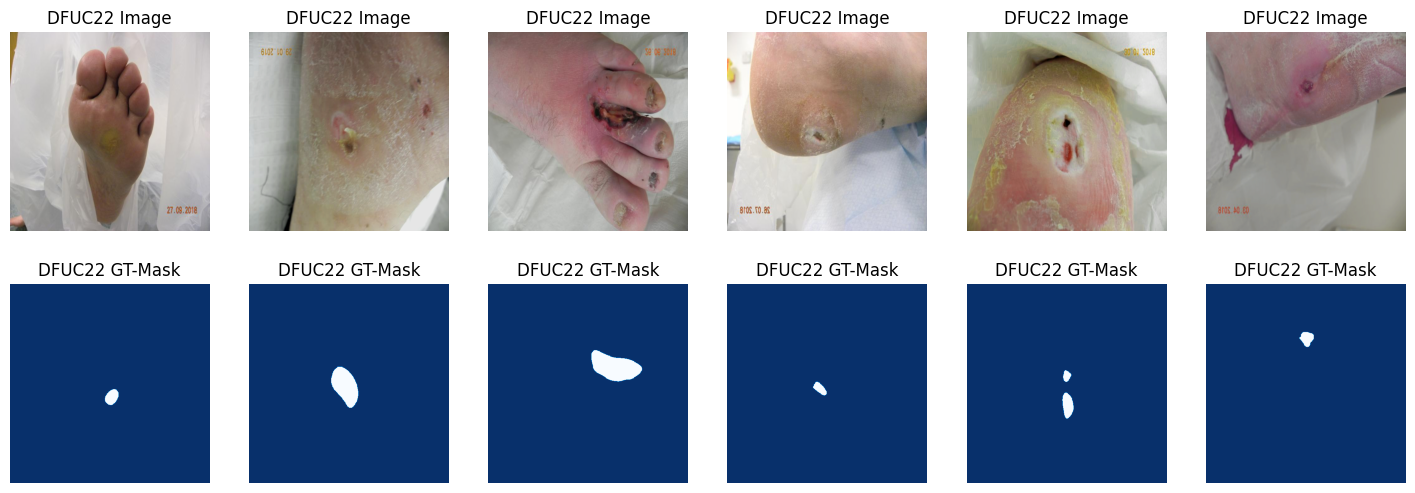

In [17]:
def denormalization(img, mean=NORM_MEAN, std=NORM_STD):
    # denormalize pixel values of [-1,1] to [0,1] 
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img

def show_subset(images, masks, n):   
    fig, ax = plt.subplots(2, n, figsize=(n*3,6))
    for i in range(n):
        ax[0, i].imshow(denormalization(np.rollaxis(images[i,:,:,:],0,3)), vmin=0, vmax=1, cmap='gray') # denormalize the image and convert to channel last format
        ax[1, i].imshow(masks[i,:,:], vmin=0, vmax=1, cmap='Blues_r')
        ax[0, i].set_title('DFUC22 Image')
        ax[1, i].set_title('DFUC22 GT-Mask')
        ax[1, i].axis('off')
        ax[0, i].axis('off')
    plt.show()

images, masks = next(dataiter) # get a batch of the training data loader
show_subset(images.numpy(), masks.numpy(), n=6) # show the first n images and masks of the batch

## Defining the model

In [ ]:
# defining the segmentation head
class SegHead(torch.nn.Module):
    """
    Segmentation head class which transforms the low dim. feature map of the dinov2 backbone to a low dim. binary segmentation map and upsamples it to the original image size
    embed_dim: int - output feature dimension of the backbone
    patch_size: int - size of the patches used in the backbone
    num_patches: int - number of patches used in the backbone
    none_linear_head: bool - if True, a non-linear head is used, otherwise a linear head is used
    num_labels: int - number of labels for the segmentation task
    """
    def __init__(self, embed_dim, patch_size, num_patches, none_linear_head=False, num_labels=1):
        super().__init__()
        self.embed_dim = embed_dim # output feature dimension of the backbone
        self.height_feature_map, self.width_featur_map = int(num_patches ** (1/2)), int(num_patches ** (1/2)) # size of the low dim. dinov2 output feature map
        
        # define the segmentation head which transforms the low dim. feature map of the dinov2 backbone to a low dim. binary segmentation map
        self.classifier = torch.nn.Sequential(
            torch.nn.Conv2d(embed_dim, embed_dim // 4, (1,1)),
            torch.nn.SiLU(),
            torch.nn.Conv2d(embed_dim // 4, num_labels, (1,1)),
        ) if none_linear_head else torch.nn.Conv2d(embed_dim, num_labels, (1,1))
        
        # upsample the low dim. binary segmentation map to the size of the original image size
        self.up = torch.nn.Upsample(scale_factor=patch_size, mode='bilinear', align_corners=False)

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height_feature_map, self.width_featur_map, self.embed_dim) # reshape the dinov2 embeddings to a 2D feature map
        embeddings = embeddings.permute(0,3,1,2) # permute the dimensions to (B, C, H, W)
        logits = self.classifier(embeddings) # pass the embeddings through the segmentation head
        return self.up(logits) # return upsampled logits
         

# defining the model including the backbone and the segmentation head
class Model(torch.nn.Module):
  """
    Model class which combines the backbone and the segmentation head
    backbone: torch.nn.Module - the backbone model
    n_backbone_layers: int - number of embeddings used from the last n blocks of the backbone
    none_linear_head: bool - if True, a non-linear head is used, otherwise a linear head is used
    num_labels: int - number of labels for the segmentation task
  """
  def __init__(self, backbone, n_backbone_layers, none_linear_head, num_labels):
    super().__init__()
    self.backbone = backbone # dinov2 backbone model
    self.n_backbone_layers = n_backbone_layers # number of embeddings used from the last n blocks of the backbone
    self.classifier = SegHead(backbone.embed_dim * n_backbone_layers, backbone.patch_size, backbone.patch_embed.num_patches, none_linear_head, num_labels) # segmentation head

  def forward(self, images):
    outputs = self.backbone.get_intermediate_layers(images, n=self.n_backbone_layers, norm=True) # get the embeddings from the backbone
    outputs = torch.cat(outputs, dim=-1) # concatenate the embeddings from the last n blocks
    logits = self.classifier(outputs) # pass the embeddings through the segmentation head
    return logits



# initialize the model
print("Creating model")
dinov2_backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg', img_size=(518,518)) # load the dinov2 backbone model from torch hub
# freeze dinov2 backbone layers 
for param_name, param in dinov2_backbone.named_parameters():
    param.requires_grad = False


# create the final model with the dinov2 backbone and the segmentation head
model = Model(dinov2_backbone, n_backbone_layers=1, none_linear_head=False, num_labels=1) # linear probing
#model = Model(dinov2_backbone, n_backbone_layers=4, none_linear_head=False, num_labels=1) # multi linear probing
#model = Model(dinov2_backbone, n_backbone_layers=4, none_linear_head=True, num_labels=1) # multi non-linear probing

# load model checkpoints if available
CHECKPOINTS = None 
if CHECKPOINTS:
    model.load_state_dict(torch.load(f'{CHECKPOINTS}', map_location='cpu'))
    torch.cuda.empty_cache()
    print(f"use model checkpoints: {CHECKPOINTS}")


device = ("cuda" if torch.cuda.is_available() else "cpu") 
print(f"Using device: {device}")
model = model.to(device, non_blocking=True) # move the model to the device

print(model)

## Train the model

### define the loss function, optimizer and metrics for training

In [19]:
# loss function
loss_function = DiceLoss(mode='binary', from_logits=True)

# optimizer 
LEARN_RATE = 1e-04
optimizer = torch.optim.AdamW(filter(lambda param: param.requires_grad, model.parameters()), lr=LEARN_RATE)

scaler = GradScaler() # gradient scaler for mixed precision training

# metrics
loss_metric = MeanMetric().to(device)
metrics = MetricCollection({
    "dice": BinaryF1Score(threshold=0.5),
    'iou': BinaryJaccardIndex(threshold=0.5)
}).to(device)

# logs
logs = {'loss': [], 'iou': [], 'dice': [], 'val_loss': [], 'val_iou': [], 'val_dice': []}

### training loop

In [ ]:
NUM_EPOCHS = 150 # number of epochs to train
 

start_training = time.perf_counter() # start time of training

for epoch in range(NUM_EPOCHS):
    epoch_start = time.perf_counter() # start time of epoch
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    
    ############################## train phase ####################################
    model.train() # set model to training mode
    optimizer.zero_grad(set_to_none=True) # zero the parameter gradients
        
    # iterate over training batches
    for (images, labels) in train_loader:
        images = images.to(device, non_blocking=True) # move images to device
        labels = labels.to(device, non_blocking=True).unsqueeze(dim=1) # move labels to device and add channel dimension
        
        # forward with mixed precision
        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images)
            loss = loss_function(outputs, labels)

        scaler.scale(loss).backward() # backpropagate the loss
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip gradients to avoid exploding gradients
        scaler.step(optimizer) # update the model parameters
        scaler.update() # update the gradient scaler
        optimizer.zero_grad(set_to_none=True) # zero the parameter gradients
        
        # Compute training metrics for the batch
        loss_metric.update(loss.detach())
        preds = outputs.sigmoid().detach()
        metrics.update(preds, labels.int())


    # compute and reset metrics states
    epoch_loss = loss_metric.compute()
    epoch_metrics = metrics.compute()
    loss_metric.reset()
    metrics.reset()
    
    # append results of training metrics to logs
    logs['loss'].append(epoch_loss.cpu().item())
    logs['dice'].append(epoch_metrics['dice'].cpu().item())
    logs['iou'].append(epoch_metrics['iou'].cpu().item())
    print(f"loss: {logs['loss'][epoch]:.5f}, dice: {logs['dice'][epoch]:.5f}, iou: {logs['iou'][epoch]:.5f}", end=' || ')


    optimizer.zero_grad(set_to_none=True)
    torch.cuda.empty_cache()

    ############################## valid phase ####################################
    with torch.no_grad():
        model.eval()

        # iterate over validation batches
        for (images, labels) in valid_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).unsqueeze(dim=1)
            
            # forward with mixed precision
            with autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(images)
                loss = loss_function(outputs, labels)

            # Compute metrics for the batch
            loss_metric.update(loss.detach())
            preds = outputs.sigmoid().detach()
            metrics.update(preds, labels.int())

        # compute and reset metrics states
        epoch_loss = loss_metric.compute()
        epoch_metrics = metrics.compute()
        loss_metric.reset()
        metrics.reset()

        # append results of validation metrics to logs
        logs['val_loss'].append(epoch_loss.cpu().item())
        logs['val_dice'].append(epoch_metrics['dice'].cpu().item())
        logs['val_iou'].append(epoch_metrics['iou'].cpu().item())
        print(f"val_loss: {logs['val_loss'][epoch]:.5f}, val_dice: {logs['val_dice'][epoch]:.5f}, val_iou: {logs['val_iou'][epoch]:.5f}", end=' || ')
                           
    # save logs as csv file
    logs_df = pd.DataFrame(logs)
    logs_df.to_csv(f'{MODEL_DIR}train_history.csv', index_label='epoch', sep=',', encoding='utf-8')

    # save model checkpoints every 10 epochs
    if (epoch % 10) == 0:
        torch.save(model.state_dict(), f'{MODEL_DIR}model_epoch{epoch}.pth')
        torch.save(optimizer.state_dict(), f'{MODEL_DIR}optimizer_epoch{epoch}.pth')
        torch.save(scaler.state_dict(), f'{MODEL_DIR}mp_scaler_epoch{epoch}.pth')
    
    epoch_end = time.perf_counter() # end time of epoch
    print(f"epoch runtime: {epoch_end-epoch_start:5.3f} sec.")
    torch.cuda.empty_cache()


# save the final model checkpoints
torch.save(model.state_dict(), f'{MODEL_DIR}model_epoch{epoch}.pth')
torch.save(optimizer.state_dict(), f'{MODEL_DIR}optimizer_epoch{epoch}.pth')
torch.save(scaler.state_dict(), f'{MODEL_DIR}mp_scaler_epoch{epoch}.pth')

end_training = time.perf_counter() # end time of trainig
print(f'Training succeeded in {(end_training - start_training):5.3f}s')

### Visualization of the training process

In [ ]:
metrics_keys = ['loss', 'iou', 'dice']
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

for i, metric in enumerate(metrics_keys):
    ax[i].plot(logs[metric], label='train')
    ax[i].plot(logs[f'val_{metric}'], label='valid')
    ax[i].set_title(f'Model {metric}')
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0, NUM_EPOCHS-1)
    ax[i].set_ylabel(metric)
    ax[i].set_xlabel('Epoch')
    ax[i].legend(loc='best')
    
fig.tight_layout()
fig.savefig(f'{MODEL_DIR}/training_history.png', dpi=100, format="png")
plt.show()

## Final evaluation 

In [ ]:
# final evaluation metrics 
metrics = MetricCollection({
    "dice": BinaryF1Score(threshold=0.5),
    'iou': BinaryJaccardIndex(threshold=0.5),
    'recall': BinaryRecall(threshold=0.5),
    'precision': BinaryPrecision(threshold=0.5),
    'cm': BinaryConfusionMatrix(normalize=None, threshold=0.5)
})

# iterate over evaluation batches
with torch.no_grad():
    model.eval()
    for (images, masks) in tqdm(valid_loader):
        images, labels = images.to(device), masks.unsqueeze(dim=1).int() # transfer images to the GPU for model inference

        # model inference for each image in the batch
        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images)
            
        prediction_probabilities = torch.sigmoid(outputs) # compute the model prediction probabilities from logits output
        prediction_masks = (prediction_probabilities > 0.5).int() # threshold prediction probabilities: if > 0.5 ulcer else background
        
        # compute the evaluation metrics for the batch
        metrics.update(prediction_masks.cpu(), labels)
    

# compute the final evaluation metrics
eval_metrics = metrics.compute()
eval_metrics["fpv"] = eval_metrics['cm'][0,1] / (eval_metrics['cm'][0,1] + eval_metrics['cm'][0,0])
eval_metrics["fnv"] = eval_metrics['cm'][1,0] / (eval_metrics['cm'][1,0] + eval_metrics['cm'][1,1])
eval_metrics["ncm"] = eval_metrics["cm"] / torch.sum(eval_metrics["cm"], dim=1, keepdim=True)

# Print the metrics to the console
print(f"Testdata evaluation results:\n", 
      f"IoU: {eval_metrics['iou']:.5f}\n",
      f"Dice: {eval_metrics['dice']:.5f}\n",
      f"Recall: {eval_metrics['recall']:.5f}\n",
      f"Precision: {eval_metrics['precision']:.5f}\n",
      f"FPE: {eval_metrics['fpv']:.5f}\n",
      f"FNE: {eval_metrics['fnv']:.5f}\n"
)

# Save the metrics as a JSON file
import json

# Function to convert tensors to standard Python data types
def convert_tensors(metrics_dict):
    converted_metrics = {}
    for key, value in metrics_dict.items():
        if isinstance(value, (np.ndarray, list, torch.Tensor)):
            converted_metrics[key] = value.tolist()
        elif hasattr(value, 'item'):  # for single-value tensors
            converted_metrics[key] = value.item()
        else:
            converted_metrics[key] = value
    return converted_metrics
    
converted_metrics = convert_tensors(eval_metrics)

with open(f'{MODEL_DIR}/eval_metrics.json', 'w') as f:
    json.dump(converted_metrics, f)

### Final evaluation confusion matrix

In [ ]:
cm = eval_metrics['cm'].numpy()
ncm = eval_metrics['ncm'].numpy()
print(f"confusion matrix:\n{cm}\n"
     f"normalized confusion matrix:\n{ncm}")

# plot confusion matrix
fig, ax = plt.subplots(1,1)
cm_fig = ax.imshow(ncm, interpolation='nearest', cmap="Blues") # plot confusion matrix background color 
fig.colorbar(cm_fig, ax=ax) # add confusion matrix color bar
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(['background', 'ulcer'])
ax.set_yticklabels(['background', 'ulcer'])
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth') 
ax.set_title("Confusion Matrix")

# plot confusion matrix values
for ix, iy in np.ndindex(ncm.shape):
    ax.text(iy, ix, f"{100*ncm[ix, iy]:.2f}%", horizontalalignment="center", color="white" if ncm[ix, iy] > ncm.max() / 2.0 else "black")

fig.savefig(f'{MODEL_DIR}/confusion_matrix.png', dpi=100, format="png")
plt.show()    

### Inference for some images with visualization

In [25]:
def show_predictions(images, masks, prediction_masks, n=6):
    images = images.cpu().numpy() 
    masks = masks.cpu().numpy()
    prediction_masks = prediction_masks.cpu().numpy()
    
    fig, ax = plt.subplots(3, n, figsize=(n*3,9))
    for i in range(n):
        ax[0, i].imshow(denormalization(np.rollaxis(images[i,:,:,:],0,3)), vmin=0, vmax=1, cmap='gray') # denormalize the image and convert to channel last format
        ax[1, i].imshow(masks[i,:,:], vmin=0, vmax=1, cmap='Blues_r')
        ax[2, i].imshow(prediction_masks[i,:,:], vmin=0, vmax=1, cmap='Blues_r')
        ax[0, i].set_title('Image')
        ax[1, i].set_title('Ulcer GT-Mask')
        ax[2, i].set_title('Ulcer Pred. Mask')
        ax[0, i].axis('off')
        ax[1, i].axis('off')
        ax[2, i].axis('off')
    plt.show()

dataiter = iter(valid_loader) # get iterator of validation data loader

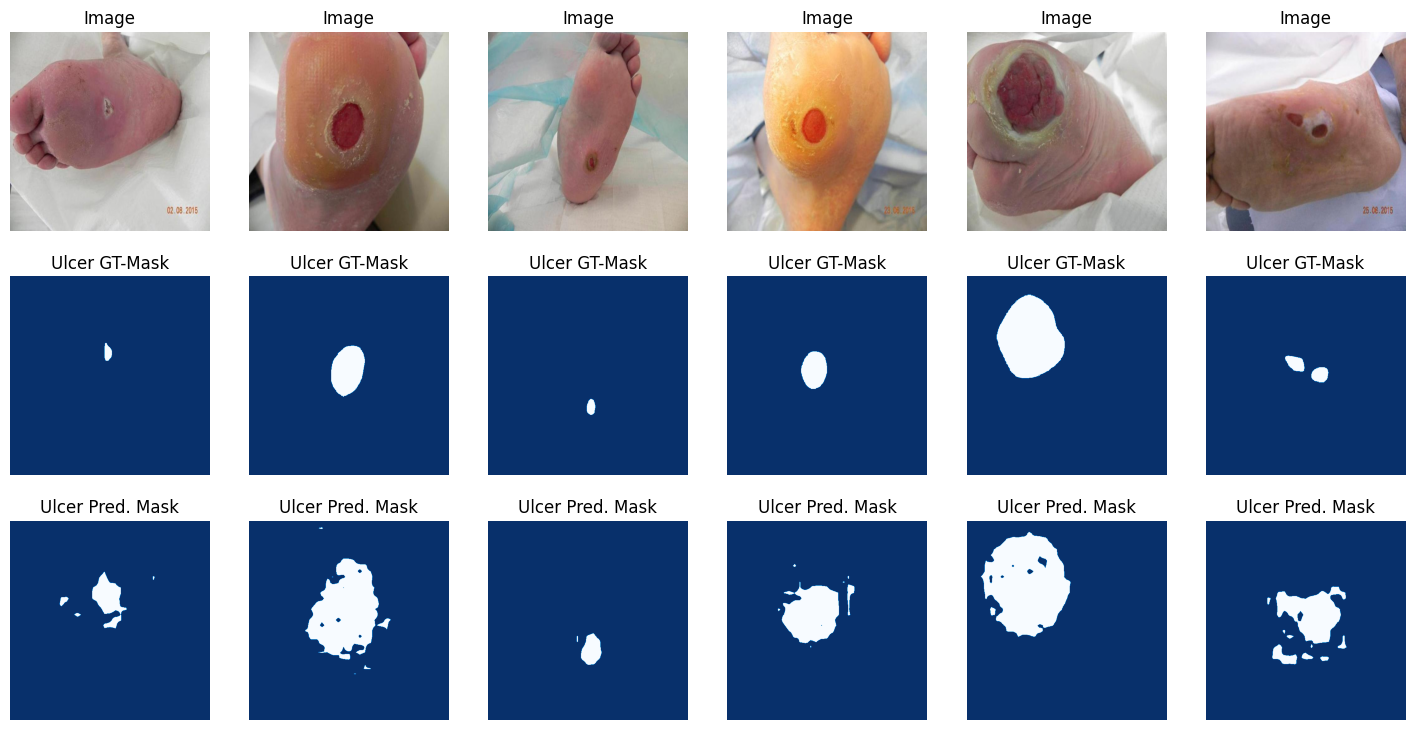

In [26]:
images, labels = next(dataiter) # get a batch of the validation data loader
images = images.to(device) # move images to the device

# model inference for the batch
with torch.no_grad():
    model.eval()
    outputs = model(images)

prediction_probabilities = torch.sigmoid(outputs) # compute the model prediction probabilities from logits output 
prediction_masks = (prediction_probabilities > 0.5).float().squeeze(1) # threshold prediction probabilities: if > 0.5 ulcer else background

show_predictions(images, labels, prediction_masks, n=6) # show the first n images, ground truth masks and predicted masks of the batch